In [2]:
import s3fs
import xarray as xr
import xesmf
import matplotlib.pyplot as plt 
import numpy as np

In [10]:
## create specific humidity function
def cal_specific_humid(Tdew,P):
    """
    calculate the specific humidity in kg/kg from ERA5 inputs. 
    assumes that Tdew is in Kelving and P is in pascals (the raw data)
    
    """
    assert Tdew.shape == P.shape, "Temperature and Pressure should be the same shape"
    
    e = 6.112*np.exp((17.67*(Tdew-273.15))/((Tdew-273.15)+243.5))
    q = ((0.622*e)/((P/100) - 0.378*e)) #kg per kg
    return(q)
    

In [4]:
## create a list of inputs to loop over 
## these are a names that correspond to the era5 data sets
data_varaibles = [f'air_temperature_at_2_metres',f'surface_air_pressure',f'dew_point_temperature_at_2_metres']
name_variables = [f'T2D',f'PSFC',f'Q2D','U2D','V2D','SWDOWN','LWDOWN','RAINRATE']

In [7]:
## load in data set of geogrid and then create a subset of curvilinear grid 
## to output the dset data to load
geogrid = xr.open_dataset('./geogrid-files/geo_em.d01.milwaukee.nc')
print(geogrid.attrs)
ds_out = xr.Dataset(
    {
        "lat": (["y","x"],geogrid.XLAT_M[0].values),
        "lon": (["y","x"], geogrid.XLONG_M[0].values),
    }
)



{'TITLE': 'OUTPUT FROM GEOGRID V4.2', 'SIMULATION_START_DATE': '0000-00-00_00:00:00', 'WEST-EAST_GRID_DIMENSION': 100, 'SOUTH-NORTH_GRID_DIMENSION': 115, 'BOTTOM-TOP_GRID_DIMENSION': 0, 'WEST-EAST_PATCH_START_UNSTAG': 1, 'WEST-EAST_PATCH_END_UNSTAG': 99, 'WEST-EAST_PATCH_START_STAG': 1, 'WEST-EAST_PATCH_END_STAG': 100, 'SOUTH-NORTH_PATCH_START_UNSTAG': 1, 'SOUTH-NORTH_PATCH_END_UNSTAG': 114, 'SOUTH-NORTH_PATCH_START_STAG': 1, 'SOUTH-NORTH_PATCH_END_STAG': 115, 'GRIDTYPE': 'C', 'DX': 1000.0, 'DY': 1000.0, 'DYN_OPT': 2, 'CEN_LAT': 43.319992, 'CEN_LON': -88.149994, 'TRUELAT1': 41.5, 'TRUELAT2': 44.5, 'MOAD_CEN_LAT': 43.319992, 'STAND_LON': -88.15, 'POLE_LAT': 90.0, 'POLE_LON': 0.0, 'corner_lats': array([42.810055, 43.82674 , 43.82674 , 42.810055, 42.81002 , 43.826706,
       43.826706, 42.81002 , 42.80555 , 43.83123 , 43.83123 , 42.80555 ,
       42.80552 , 43.831203, 43.831203, 42.80552 ], dtype=float32), 'corner_lons': array([-88.75098 , -88.76108 , -87.53894 , -87.54901 , -88.75711 ,
 

In [8]:
fs = s3fs.S3FileSystem(anon=True) ### This is needed to be able to access wihtouth erroring
fmap = s3fs.S3Map(f's3://era5-pds/zarr/2010/07/data/{data_varaibles[2]}.zarr', s3=fs)
dset_td = xr.open_zarr(fmap, consolidated=True)
fmap = s3fs.S3Map(f's3://era5-pds/zarr/2010/07/data/{data_varaibles[1]}.zarr', s3=fs)
dset_pa = xr.open_zarr(fmap, consolidated=True)
dset_td.lon

<xarray.DataArray 'lon' (lon: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [13]:
x = dset_td.lon.values
v = (x+180)%360-180
v

array([ 0.  ,  0.25,  0.5 , ..., -0.75, -0.5 , -0.25], dtype=float32)

In [9]:
## determine the nearest coordinates of the geogrid file, and then add 2 to it to be safe
lonsv, latsv = np.meshgrid(-360+dset_td.lon.values,dset_td.lat.values)
## get the id of the lons from geogrid
LON_start = np.abs(lonsv - ds_out.lon[0,0].values)
LON_end = np.abs(lonsv - ds_out.lon[-1,-1].values)

idx_lonstart = np.where(LON_start == LON_start.min())
idx_lonend = np.where(LON_end == LON_end.min())
input_lonstart = idx_lonstart[1][0]-1
input_lonend = idx_lonend[1][0]+1


## get the id of the lats from geogrid
LAT_start = np.abs(latsv - ds_out.lat[0,0].values)
LAT_end = np.abs(latsv - ds_out.lat[-1,-1].values)

idx_latstart = np.where(LAT_start == LAT_start.min())
idx_latend = np.where(LAT_end == LAT_end.min())
input_latstart = idx_latstart[0][0]+1
input_latend = idx_latend[0][0]-1

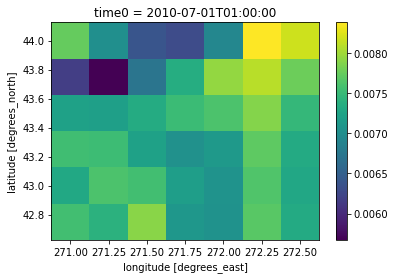

In [11]:
## take out the data of interest
dset_subset_td = dset_td[data_varaibles[2]][:,input_latend:input_latstart,input_lonstart:input_lonend]
dset_subset_pa = dset_pa[data_varaibles[1]][:,input_latend:input_latstart,input_lonstart:input_lonend]
dset_kg = cal_specific_humid(dset_subset_td, dset_subset_pa)
dset_kg[1].plot()

In [12]:
## create the subset dset
lonsv, latsv = np.meshgrid(-360+dset_subset_td.lon.values,dset_subset_td.lat.values)

data_array_input = xr.Dataset(
    {
    name_variables[0]:(["y","x"],dset_subset_td[1,:,:].values),
    }
    ,coords={
        "lat": (["y","x"],latsv),
        "lon": (["y","x"], lonsv),
    }
)   
data_array_input

<xarray.Dataset>
Dimensions:  (y: 6, x: 7)
Coordinates:
    lat      (y, x) float32 44.0 44.0 44.0 44.0 44.0 ... 42.75 42.75 42.75 42.75
    lon      (y, x) float32 -89.0 -88.75 -88.5 -88.25 ... -88.0 -87.75 -87.5
Dimensions without coordinates: y, x
Data variables:
    T2D      (y, x) float32 283.2 281.8 280.4 280.1 ... 281.9 281.9 283.2 282.5

In [13]:
regridder = xesmf.Regridder(data_array_input, ds_out, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_6x7_114x99.nc 
Reuse pre-computed weights? False 
Input grid shape:           (6, 7) 
Output grid shape:          (114, 99) 
Periodic in longitude?      False

In [14]:
dout = regridder(data_array_input)

In [21]:
dout.dims['y']

114

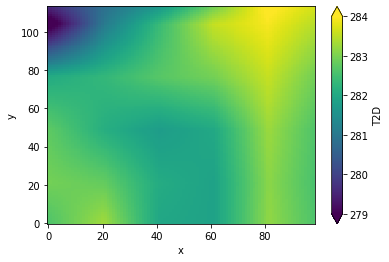

In [106]:
dout.T2D.plot(vmin=279,vmax=284)

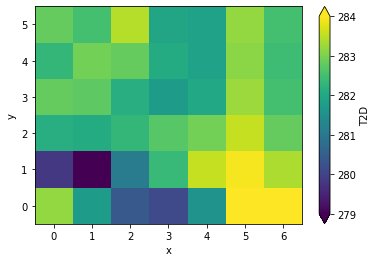

In [107]:
data_array_input.T2D.plot(vmin=279,vmax=284)

<xarray.DataArray 'surface_air_pressure' (y: 8, x: 9)>
array([[     nan,      nan,      nan,      nan,      nan, 297.8125,
        297.6875, 296.5   , 296.5   ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        297.875 , 296.875 , 296.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        295.75  , 296.625 , 296.625 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        293.375 , 294.75  , 295.9375],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        293.1875, 293.625 , 294.8125],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 293.875 , 293.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 292.5625, 292.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 291.75  , 292.25  ]], dtype=float32)
Coordinates:
    lat      (y, x) float32 42.5 42.5 42.5 42.5 42.5 ... 44.25 44.25 44.25 44.25
    lon      (y, x) float32 -89.25 -89.0 -88.75 -88.5 ... -87.75 -87.5 -87.25
Dimensions without coordinates: y, x

In [44]:
dout.surface_air_pressure[0,0]

<xarray.DataArray 'surface_air_pressure' ()>
array(nan, dtype=float32)
Coordinates:
    lon      float32 -88.75
    lat      float32 42.81

In [62]:
## longwave radiation
#s3://jupiter-reference-data/era5/rlds/surface_thermal_radiation_downwards_1980_01-03.nc

import os
import xarray as xr

variable_name_longwave = 'surface_thermal_radiation_downwards'
data_variable_longwave = 'strd'
file_name = f'{variable_name}_1980_01-03.nc'

os.system(f'aws s3 cp s3://jupiter-reference-data/era5/rlds/{file_name} .')
darr = xr.open_dataset(file_name)[data_variable]
darr

download: s3://jupiter-reference-data/era5/rlds/surface_thermal_radiation_downwards_1980_01-03.nc to ./surface_thermal_radiation_downwards_1980_01-03.nc


<xarray.DataArray 'strd' (time: 2184, latitude: 721, longitude: 1440)>
[2267516160 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 ... 1980-03-31T23:00:00
Attributes:
    units:      J m**-2
    long_name:  Surface thermal radiation downwards

In [63]:
import s3fs
import xarray as xr
import xesmf
import numpy as np
import pandas as pd
import os

"""
This code assumes that you are going to start at the BEGINNING OF A MONTH to generate the inputs. 
"""

############## options to set examples
#start_date_want = '2010-06-01' #set
#end_date_want = '2010-11-01' #set
#freq_want = '1H' #era5 is 1H
#save_location = './' #save location for data
#geo_file = './geogrid-files/geo_em.d01.milwaukee.nc' #location and name of file
#################


######################## Define all important functions

def cal_specific_humid(Tdew,P):
    """
    calculate the specific humidity in kg/kg from ERA5 inputs. 
    assumes that Tdew is in Kelving and P is in pascals (the raw data)
    
    """
    
    
    e = 6.112*np.exp((17.67*(Tdew-273.15))/((Tdew-273.15)+243.5))
    q = ((0.622*e)/((P/100) - 0.378*e)) #kg per kg
    
    return(q)

def get_region_era5(era5,geo):
    
    """
    Takes an era5 file, and a geogrid file, and then calculates the start and end points 
    of the era5 file based on the geogrid file. Adds 3 to each edge of the ERA5 data for 
    a safety protocol
    """
    
    ## determine the nearest coordinates of the geogrid file, and then add 3
    lonsv, latsv = np.meshgrid((era5.lon.values+180)%360-180,era5.lat.values)
    ## this is ERA5 specific!
    
    ## get the id of the lons from geogrid
    LON_start = np.abs(lonsv - geo.lon[0,0].values)
    LON_end = np.abs(lonsv - geo.lon[-1,-1].values)

    idx_lonstart = np.where(LON_start == LON_start.min())
    idx_lonend = np.where(LON_end == LON_end.min())
    input_lonstart = idx_lonstart[1][0]-3
    input_lonend = idx_lonend[1][0]+3


    ## get the id of the lats from geogrid
    LAT_start = np.abs(latsv -geo.lat[0,0].values)
    LAT_end = np.abs(latsv - geo.lat[-1,-1].values)

    idx_latstart = np.where(LAT_start == LAT_start.min())
    idx_latend = np.where(LAT_end == LAT_end.min())
    input_latstart = idx_latstart[0][0]+3
    input_latend = idx_latend[0][0]-3
    
    return(input_lonstart,input_lonend,input_latend,input_latstart) # order due to the way era5 defines coordinates

def transform_era5_to_dataarray_2d(dsubset):
    
    """
    takes a zarr dataarray, and creates a dataset that has the correct lats and lons to 
    feed into HRLDAS
    """
    
    lonsv, latsv = np.meshgrid((dsubset.lon.values+180)%360-180,dsubset.lat.values) 
    # meshgrid is based on the notation of ERA5 data! !!SHOULD BE CHANGED IF USING ANOTHER analysis forcing

    data_array_input = xr.Dataset(
        {
        name_variables[0]:(["y","x"],dsubset[0,1:-1,1:-1].values),
        }
        ,coords={
            "lat": (["y","x"],latsv[1:-1,1:-1]),
            "lon": (["y","x"], lonsv[1:-1,1:-1]),
            "lat_b": (["y_b","x_b"], 0.25*(latsv[:-1,:-1]+latsv[1:,1:]+latsv[1:,:-1]+latsv[:-1,1:])),
            "lon_b": (["y_b","x_b"], 0.25*(lonsv[:-1,:-1]+lonsv[1:,1:]+lonsv[1:,:-1]+lonsv[:-1,1:])),
            
            
        }
    )   
    return(data_array_input)

def transform_era5_to_dataarray_3d(dsubset3d,name):
    
    """
    takes a zarr dataarray, and creates a dataset that has the correct lats and lons to 
    feed into HRLDAS
    """
    
    lonsv, latsv = np.meshgrid((dsubset3d.lon.values+180)%360-180,dsubset3d.lat.values) 
    # meshgrid is based on the notation of ERA5 data! !!SHOULD BE CHANGED IF USING ANOTHER analysis forcing

    data_array_input = xr.Dataset(
        {
        name:(["time","y","x"],dsubset3d[:,1:-1,1:-1].values),
        }
        ,coords={
            "lat": (["y","x"],latsv[1:-1,1:-1]),
            "lon": (["y","x"], lonsv[1:-1,1:-1]),
            "lat_b": (["y_b","x_b"], 0.25*(latsv[:-1,:-1]+latsv[1:,1:]+latsv[1:,:-1]+latsv[:-1,1:])),
            "lon_b": (["y_b","x_b"], 0.25*(lonsv[:-1,:-1]+lonsv[1:,1:]+lonsv[1:,:-1]+lonsv[:-1,1:])),
            
            
        }
    )   
    return(data_array_input)


def get_regridder(grid_input,grid_out,option="bilinear"):
    """
    this function takes the two grids, and gets a regridder that we can use to get all gridded data!
    depends on xemsf.
    Option should be the method you want, default is "bilinear"
    """
    regridder_weights=xesmf.Regridder(grid_input, grid_out, option)
    return(regridder_weights)
    
######################################################################
# begin actual code (run function)

def run(start_date, end_date, freq_want, save_location, geo_file):
    
    
    
    ## create a list of inputs to loop over (data is ERA5, NAME is the names HRLDAS is looking for)
    data_variables = [f'air_temperature_at_2_metres',f'surface_air_pressure',f'dew_point_temperature_at_2_metres',
                     f'eastward_wind_at_10_metres',f'northward_wind_at_10_metres',
                     f'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation',
                     f'precipitation_amount_1hour_Accumulation',f'strd'] ## these are what ERA5 is defining (zarr format)
    
    name_variables = [f'T2D',f'PSFC',f'Q2D',f'U2D',f'V2D',f'SWDOWN',f'RAINRATE','LWDOWN'] ## these are what HRLDAS is looking for (no change)
    
    variable_name_longwave = 'surface_thermal_radiation_downwards' ## this needs to be used to access the ERA5 data that was pre-downloaded

    geogrid = xr.open_dataset(geo_file) # load in geofile

    ##grab the geogrid file to create the regridder (only once)
    ds_out = xr.Dataset(
        {
            "lat": (["y","x"],geogrid.XLAT_M[0].values),
            "lon": (["y","x"], geogrid.XLONG_M[0].values),
            "lat_b": (["y_b","x_b"],geogrid.XLAT_C[0].values),
            "lon_b": (["y_b","x_b"],geogrid.XLONG_C[0].values)
        }
    )

    ## load in a SINGLE time zarr file that is independent of the time loop below. This will allow us to calculate the 
    ## boundaries of the 
    fs = s3fs.S3FileSystem(anon=True) ### This is needed to be able to access wihtouth erroring
    fmap = s3fs.S3Map(f's3://era5-pds/zarr/2010/07/data/{data_varaibles[0]}.zarr', s3=fs) ## path to era5 data
    dset_t = xr.open_zarr(fmap, consolidated=True) #grab a single zarr file 
    
    
    ##grab the subset of data
    subset_lon_start,subset_lon_end,subset_lat_start,subset_lat_end = get_region_era5(dset_t,ds_out)



    # Example on how to use the output
    # of era5 region dset_subset_td = dset_td[data_varaibles[2]][:,subset_lat_start:subset_lat_end,subset_lon_start:subset_lon_end]
    _temp =  dset_t[data_varaibles[0]][:,subset_lat_start:subset_lat_end,subset_lon_start:subset_lon_end]
    data_array_era5 = transform_era5_to_dataarray_2d(_temp)

    ## now we get the regridder weights (only need this once)
    regridder_era5_to_geogrid = get_regridder(data_array_era5,ds_out)
    regridder_era5_to_geogrid_conserve = get_regridder(data_array_era5,ds_out,"conservative")

    ## works up to here!
    dates_to_loop = pd.date_range(start=start_date_want,end=end_date_want, freq=freq_want)
    date_year = str(dates_to_loop[0].year)
    date_month = str(dates_to_loop[0].month).zfill(2)

    variables_to_save = {} # create an empty dictionary 

    for ii, date in enumerate(dates_to_loop): # we loop over each of these values

        # naming convention is of the format
        # YYYYMMDDHH.LDASIN_DOMAIN1

        output_file_name = str(date.year).zfill(4) + str(date.month).zfill(2) + str(date.day).zfill(2) + str(date.hour).zfill(2) + '.LDASIN_DOMAIN1'

        ## increment the longwave data

        date_month_new = str(date.month).zfill(2)

        ## determine if we need to load in a new data set
        if ii == 0:
            load_new = True
        elif date_month_new == date_month:
            load_new = False
        else:
            date_month = date_month_new
            load_new = True
            print(date_month)

        if (date.month % 3  == 1) or (ii == 0):
            load_LWDOWN = True
        else:
            load_LWDOWN = False


        ## if we should load the data  LOAD IT
        if load_new:
            for era5_name, output_name in zip(data_variables, name_variables):

                # do we need to load in longwave data? It is collected every three months
                if (output_name == 'LWDOWN') and (load_LWDOWN): #LWDOWN branch
                    
                    # which ending do we need?
                    if (date.month>= 1) and (date.month<=3):
                        end_string = f'_01-03.nc'
                    elif(date.month>= 4) and (date.month<=6):
                        end_string = f'_04-06.nc'
                    elif(date.month>= 7) and (date.month<=9):
                         end_string = f'_07-09.nc'
                    else:
                        end_string = f'_10-12.nc'

                    # create the file that we need to load in
                    file_name_LW = f'{variable_name_longwave}_'+date_year+end_string

                    # actually load it in (ERA5 SPECIFIC)
                    os.system(f'aws s3 cp s3://jupiter-reference-data/era5/rlds/{file_name_LW} .')
                    dLW = xr.open_dataset(file_name_LW)[era5_name]
                    dLW = dLW.rename({'longitude':'lon','latitude':'lat','time':'time'})
                    
                    # We divide by 3600 to get the W/m^2
                    dset_loop_sm = dLW[:,subset_lat_start:subset_lat_end,subset_lon_start:subset_lon_end]/3600
                    dset_data_array = transform_era5_to_dataarray_3d(dset_loop_sm,output_name)

                    variables_to_save[output_name] = regridder_era5_to_geogrid(dset_data_array[output_name])#ensures this is a dataarray
                    
                    ## meta data and fixing the attributes
                    variables_to_save[output_name].attrs = {'units':'W/m^2'}
                    variables_to_save[output_name] = variables_to_save[output_name].reset_coords(drop=True)
                    variables_to_save[output_name] = variables_to_save[output_name].swap_dims({'time':'Time','y':'south_north','x':'west_east'})
                    

                else:
    
                    ## load in the data (ERA5 SPECIFIC)
                    fs = s3fs.S3FileSystem(anon=True) ### This is needed to be able to access wihtouth erroring
                    fmap = s3fs.S3Map(f's3://era5-pds/zarr/{date_year}/{date_month}/data/{era5_name}.zarr', s3=fs)
                    dset_loop = xr.open_zarr(fmap, consolidated=True)


                    # if rain or if solar radiation, we divide by 3600. if anything else, we divide by 1 (keep it the same)
                    if (output_name == 'SWDOWN'):
                        divisor = 3600
                    elif (output_name == 'RAINRATE'):
                        divisor = 1000/3600 #rainfall is in m 
                    else:
                        divisor = 1

                    # subset the data
                    dset_loop_sm = dset_loop[era5_name][:,subset_lat_start:subset_lat_end,subset_lon_start:subset_lon_end]/divisor
                    dset_data_array = transform_era5_to_dataarray_3d(dset_loop_sm,output_name)
                   

                    ## regrid
                    ## do we need to conserve the data? 
                    if (output_name == 'RAINRATE'):
                        variables_to_save[output_name] = regridder_era5_to_geogrid_conserve(dset_data_array[output_name])#makes this a dataarray
                    else:
                        variables_to_save[output_name] = regridder_era5_to_geogrid(dset_data_array[output_name])#makes this a dataarray
                    
                    ## meta data and fixing the attributes
                    if (output_name == 'T2D'):
                        variables_to_save[output_name].attrs = {'units':'K'}
                    elif  (output_name == 'PSFC'):
                        variables_to_save[output_name].attrs = {'units':'Pa'}
                    elif  (output_name == 'Q2D'):
                        variables_to_save[output_name].attrs = {'units':'Kg/kg'}
                    elif  (output_name == 'U2D'):
                        variables_to_save[output_name].attrs = {'units':'m/s'}
                    elif  (output_name == 'V2D'):
                        variables_to_save[output_name].attrs = {'units':'m/s'}
                    elif  (output_name == 'SWDOWN'):
                        variables_to_save[output_name].attrs = {'units':'W/m^2'}
                    elif  (output_name == 'RAINRATE'):
                        variables_to_save[output_name].attrs = {'units':'mm/s'}
                        
                    variables_to_save[output_name] = variables_to_save[output_name].reset_coords(drop=True)
                    variables_to_save[output_name] = variables_to_save[output_name].swap_dims({'time':'Time','y':'south_north','x':'west_east'})
                        
                    

            # get the specific humidity, and not dew point temp
            variables_to_save['Q2D'] = cal_specific_humid(variables_to_save['Q2D'],variables_to_save['PSFC'])
            ## end of the for loop to load in data if needed


        #how do we index the ZARR data?
        if ii == 0:
            index_not_LW = ii
        elif load_new: #we need to restart!
            index_not_LW = 0
        else:
            index_not_LW += 1


        if ii == 0: # we should start out at the correct time 
            if date.month == 1 or date.month == 4 or date.month == 7 or date.month == 10:
                index_LW = 0
            elif date.month == 2 or date.month == 5 or date.month == 8 or date.month == 11:
                index_LW = 24*date.days_in_month - 1 #minus 1 because of the zero index
            else:
                x = date-pd.DateOffset(months=1)
                index_LW = 24*(date.days_in_month + x.days_in_month)- 1 #minus 1 because of the zero index
        elif load_LWDOWN:
            index_LW = 0 # reset with the new netcdf
        else:
            index_LW += 1


        data_set_save = xr.Dataset(
            {
                name_variables[0]:variables_to_save[name_variables[0]].isel(Time=index_not_LW),
                name_variables[1]:variables_to_save[name_variables[1]].isel(Time=index_not_LW),
                name_variables[2]:variables_to_save[name_variables[2]].isel(Time=index_not_LW),
                name_variables[3]:variables_to_save[name_variables[3]].isel(Time=index_not_LW),
                name_variables[4]:variables_to_save[name_variables[4]].isel(Time=index_not_LW),
                name_variables[5]:variables_to_save[name_variables[5]].isel(Time=index_not_LW),
                name_variables[6]:variables_to_save[name_variables[6]].isel(Time=index_not_LW),
                name_variables[7]:variables_to_save[name_variables[7]].isel(Time=index_LW),
            },
            attrs = {'TITLE':'Output from Python Re-grid',
                     'WEST-EAST_GRID_DIMENSION':geogrid.attrs['WEST-EAST_GRID_DIMENSION'],
                     'SOUTH-NORHT_GRID_DIMENSION':geogrid.attrs['SOUTH-NORTH_GRID_DIMENSION'],
                     'DX':geogrid.attrs['DX'],
                     'DY':geogrid.attrs['DY'],
                     'TRUELAT1':geogrid.attrs['TRUELAT1'],
                     'TRUELAT2':geogrid.attrs['TRUELAT2'],
                     'LA1':geogrid.attrs['corner_lats'][0],
                     'LO1':geogrid.attrs['corner_lons'][0],
                     'STAND_LON':geogrid.attrs['STAND_LON'],
                     'MAP_PROJ':geogrid.attrs['MAP_PROJ'],
                     'MMINLU':geogrid.attrs['MMINLU'],
                    }


        )

        if save_location.startswith('s3://'):
           # First write the file locally in the current directory
           data_set_save.to_netcdf(file_name)

           # Now, use aws cli to upload
           # Make sure there isn't an extra slash
           # at the end
           save_location = save_location.strip('/')
           output_path = f'{save_location}/{file_name}'
           os.system(f'aws s3 cp {file_name} {output_path}')

        else:
            data_set_save.to_netcdf(save_location+output_file_name)
## end of run block
## basic argument parser given Luke M. 
if __name__ == '__main__':
    # Set up an argument parser object
    from argparse import ArgumentParser
    parser = ArgumentParser()
    
    # For each argument we expect, we need to tell ArgumentParser
    # to expect it

    # Here, add the 'start_date' argument
    # Note that when doing long command line flags (e.g., --start-date),
    # argparse will strip out the leading double-hyphen and convert all other hyphens
    # to underscores in the variable name.  Also, add a help string to define what this argument is.
    parser.add_argument('--start-date', type=str, help="Start date of simulation in format YYYY-MM-DD.  Must be beginning of a month")

    # Argument for end date
    parser.add_argument('--end-date', type=str, help="End date of simulation in format YYYY-MM-DD.  Must be beginning of a month")

    # Argument for frequency
    # Here we add a default of '1H', which will be assigned
    # if the user does not provide any argument to this flag
    # (could add defaults for the others too if you wanted)
    parser.add_argument('--freq', type=str, default='1H', help="Frequency of boundary condition. ERA5 defaults to 1H")

    # Argument for save_location
    parser.add_argument('--save-location', type=str, default='./', help="Path to directory location to save outputs")
    
    # Argument for geogrid file
    parser.add_argument('--geogrid-file', type=str, help="Path and name of geogrid file (GEO_EM) from WPS")
    
    # Now, tell argparse to parse command line arguments
    args = parser.parse_args()
    
    # Pass this to our run function
    run(start_date=args.start_date, end_date=args.end_date, freq_want=args.freq, save_location=args.save_location,geo_file=args.geogrid_file)


In [64]:
run('2010-06-01', '2010-11-01' ,'1H','./',  './geogrid-files/geo_em.d01.milwaukee.nc' )#location and name of file


/opt/conda/lib/python3.8/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


download: s3://jupiter-reference-data/era5/rlds/surface_thermal_radiation_downwards_2010_04-06.nc to ./surface_thermal_radiation_downwards_2010_04-06.nc


/opt/conda/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


<xarray.Dataset>
Dimensions:   (south_north: 114, west_east: 99)
Dimensions without coordinates: south_north, west_east
Data variables:
    T2D       (south_north, west_east) float32 297.4 297.4 297.4 ... 287.5 287.4
    PSFC      (south_north, west_east) float32 9.797e+04 9.796e+04 ... 9.894e+04
    Q2D       (south_north, west_east) float32 0.01089 0.01092 ... 0.009758
    U2D       (south_north, west_east) float32 0.09563 0.05282 ... -3.62 -3.648
    V2D       (south_north, west_east) float32 -0.7579 -0.7194 ... -0.739
    SWDOWN    (south_north, west_east) float32 239.3 238.8 238.2 ... 201.6 200.3
    RAINRATE  (south_north, west_east) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LWDOWN    (south_north, west_east) float32 367.2 367.7 368.2 ... 347.8 347.6
Attributes:
    TITLE:                       Output from Python Re-grid
    WEST-EAST_GRID_DIMENSION:    100
    SOUTH-NORHT_GRID_DIMENSION:  115
    DX:                          1000.0
    DY:                          1000.0
    T

NameError: name 'ddddd' is not defined

In [4]:
import s3fs
import xarray as xr
import xesmf
import numpy as np
import pandas as pd
import os













############################### Begin typical code
def run(geo_file,start_date,save_location):
    
    
    ## 
    #data_variables = [f'air_temperature_at_2_metres',f'surface_air_pressure',f'dew_point_temperature_at_2_metres',
    #                 f'eastward_wind_at_10_metres',f'northward_wind_at_10_metres',
    #                 f'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation',
    #                 f'precipitation_amount_1hour_Accumulation',f'strd'] ## these are what ERA5 is defining (zarr format)
    
    HRLDAS_name_variables = [f'Times',f'XLAT',f'XLONG',f'TMN',f'HGT',f'SEAICE',f'MAPFAC_MX',f'MAPFAC_MY',
                            f'SHDMAX',f'SHDMIN',f'LAI',f'XLAND',f'IVGTYP',f'ISLTYP',f'SNOW',f'CANWAT',
                            f'TSK',f'DZS',f'ZS',f'TSLB',f'SMOIS'] ## these are what HRLDAS is looking for (no change)
    
    #These are the units that are saved in the initial conditions
    units = {
                        'XLAT' : 'degrees_north',
                        'XLONG' : 'degrees_east',
                        'TMN' : 'K',
                        'HGT' :'m',
                        'SEAICE' : '-',
                        'MAPFAC_MX' : '-',
                        'MAPFAC_MY' : '-',
                        'SHDMAX' : '%',
                        'SHDMIN' : '%',
                        'LAI' : 'm^2/m^2',
                        'XLAND' : '-',
                        'IVGTYP' : '-',
                        'ISLTYP' : '-',
                        'SNOW' : 'kg/m^2', #mm since a kg of water over a square meter is a depth of a mm
                        'CANWAT' : 'kg/m^2', #mm since a kg of water over a square meter is a depth of a mm
                        'TSK' : 'K', # surface radiative temperature
                        'DZS' : 'm', # depth of the individual layers
                        'ZS' : 'm', # depth of the the entire layer 
                        'TSLB' : 'K' # soil layer temperature
                        'SMOIS' : 'm^3/m^3', # soil layer volumetric soil mositure
                    }
    
    geogrid = xr.open_dataset(geo_file) # load in geofile

    ##grab the geogrid file to create the regridder (only once)
    ds_out = xr.Dataset(
        {
            "lat": (["y","x"],geogrid.XLAT_M[0].values),
            "lon": (["y","x"], geogrid.XLONG_M[0].values),
            "lat_b": (["y_b","x_b"],geogrid.XLAT_C[0].values),
            "lon_b": (["y_b","x_b"],geogrid.XLONG_C[0].values)
        }
    )

In [6]:
## Testing to see if this works!

import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'year': '2010',
        'month': '04',
        'day': '01',
        'time': '00:00',
        'variable': [
            'skin_reservoir_content', 'skin_temperature', 'snow_depth',
            'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3',
            'soil_temperature_level_4', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2',
            'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
        ],
    },
    'download.nc')

ModuleNotFoundError: No module named 'cdsapi'